<a href="https://colab.research.google.com/github/4nands/4nands.github.io/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.layers import Dense,Dropout,Conv2D,Flatten,MaxPool2D,Input,BatchNormalization,Activation,Add,GlobalAveragePooling2D
from keras import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.models import load_model
from keras.regularizers import l2
from keras.models import Model
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

import numpy as np
import matplotlib.pyplot as plt


def conv(filters,kernel_size,strides=1):

  return Conv2D(filters,kernel_size,strides=strides,padding='same',use_bias=False,kernel_initializer='he_normal',kernel_regularizer=l2(0.0001))

def first_residual_unit(filters,strides):

  def f(x):

    x = BatchNormalization()(x)
    b = Activation('relu')(x)

    x = conv(filters //4,1,strides)(b)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = conv(filters //4,3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = conv(filters,1)(x)

    sc = conv(filters,1,strides)(b)

    return Add()([x,sc])

  return f

def residual_unit(filters):

  def f(x):

    sc = x

    x = BatchNormalization()(x)
    b = Activation('relu')(x)

    x = conv(filters //4,1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = conv(filters //4,3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = conv(filters,1)(x)


    return Add()([x,sc])

  return f

def residual_block(filters,strides,unit_size):

  def f(x):

    x = first_residual_unit(filters,strides)(x)
    for i in range(unit_size-1):
      x = residual_unit(filters)(x)
    return x

  return f

def step_decay(epoch):

  x = 0.1

  if epoch >= 80:
    x=0.01
  if epoch >= 120:
    x = 0.001

  return x


(train_images,train_labels),(test_images,test_labels) = cifar10.load_data()

train_images = train_images.astype('float32')/255.0
test_images = test_images.astype('float32')/255.0


train_labels = to_categorical(train_labels,10)
test_labels = to_categorical(test_labels,10)

input = Input(shape=(32,32,3))

x = conv(16,3)(input)

x = residual_block(64,1,3)(x)
x = residual_block(128,2,3)(x)
x = residual_block(256,2,3)(x)

x = BatchNormalization()(x)
x = Activation('relu')(x)

x = GlobalAveragePooling2D()(x)

output = Dense(10,activation='softmax',kernel_regularizer=l2(0.0001))(x)

model = Model(inputs=input,outputs=output)

model.compile(loss='categorical_crossentropy',optimizer=SGD(learning_rate=0.1,momentum=0.9),metrics=['accuracy'])

train_images = train_images[:10240]
train_labels = train_labels[:10240]

history = model.fit(train_images,train_labels,batch_size=512,epochs=50,validation_split=0.1)

plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')


plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(test_images[i])
plt.show()

test_predictions = model.predict(test_images[0:10])
test_predictions = np.argmax(test_predictions,axis=1)
labels =['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
name = [labels[n] for n in test_predictions]
print(name)

Epoch 1/50
 4/18 ━━━━━━━━━━━━━━━━━━━━ 2:39 11s/step - accuracy: 0.0851 - loss: 2.9707

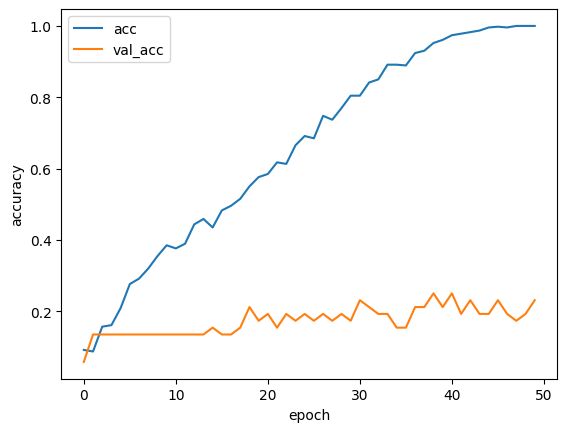

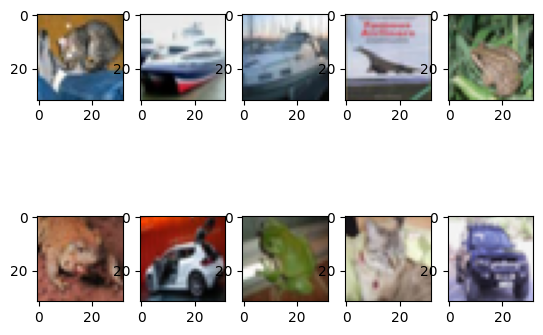

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
['dog', 'ship', 'ship', 'airplane', 'frog', 'dog', 'automobile', 'frog', 'deer', 'automobile']


In [ ]:
plt.plot(history.history['acc'],label='acc')
plt.plot(history.history['val_acc'],label='val_acc')


plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(test_images[i])
plt.show()

test_predictions = model.predict(test_images[0:10])
test_predictions = np.argmax(test_predictions,axis=1)
labels =['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
name = [labels[n] for n in test_predictions]
print(name)


In [ ]:
train_gen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    width_shift_range=0.125,
    height_shift_range=0.125,
    horizontal_flip=True
)
test_gen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True
)

for data in (train_gen,test_gen):
  data.fit(train_images)

lr_decay = LearningRateScheduler(step_decay)